In [1]:
# Course: INF 2178: Experimental Design For Data Science
# Name: Charlie Zhang
# Student number：1009855514
# Instructor: Shion Guha
# Program: Master of Information
# University of Toronto
# Assignment 3

In [2]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene, shapiro
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load the dataset and display the first few rows
dt = pd.read_csv('INF2178_A3_data.csv')

# Prepare a copy of dataset
dt_copy = dt.copy()

# Display the first few rows
dt.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


# **EDA**#

In [4]:
# Check the data type and if there is missing values
dt.info()   # No missing value found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fallreadingscore             11933 non-null  float64
 1   fallmathscore                11933 non-null  float64
 2   fallgeneralknowledgescore    11933 non-null  float64
 3   springreadingscore           11933 non-null  float64
 4   springmathscore              11933 non-null  float64
 5   springgeneralknowledgescore  11933 non-null  float64
 6   totalhouseholdincome         11933 non-null  float64
 7   incomeinthousands            11933 non-null  float64
 8   incomegroup                  11933 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 839.2 KB


In [5]:
# Summary of the dataset
dt_summary = dt.describe()
dt_summary

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
count,11933.000000,11933.000000,11933.000000,11933.000000,11933.000000,11933.000000,11933.000000,11933.000000,11933.000000
mean,35.954215,27.128244,23.073694,47.511178,37.799461,28.235584,54317.199930,54.317200,1.895165
std,10.473130,9.120505,7.396978,14.327111,12.027753,7.577457,36639.061147,36.639061,0.822692
min,21.010000,10.510000,6.985000,22.350000,11.900000,7.858000,1.000000,0.001000,1.000000
25%,29.340000,20.680000,17.385000,38.950000,29.270000,22.802000,27000.000000,27.000000,1.000000
50%,34.060000,25.680000,22.954000,45.320000,36.410000,28.583000,47000.000000,47.000000,2.000000
75%,39.890000,31.590000,28.305000,51.770000,44.220000,33.782000,72000.000000,72.000000,3.000000
max,138.510000,115.650000,47.691000,156.850000,113.800000,48.345000,150000.000000,150.000000,3.000000


In [6]:
# Capture and display the 'incomegroup' rank and the minimum and maximum value for EDA
income_groups = dt.pivot_table(index='incomegroup', values='totalhouseholdincome', aggfunc=['min', 'max','count'])
income_groups.columns = ['Min', 'Max','Count']
income_groups

,Min,Max,Count
incomegroup,,,
1,1.0,39800.0,4729
2,40000.0,69700.0,3726
3,70000.0,150000.0,3478


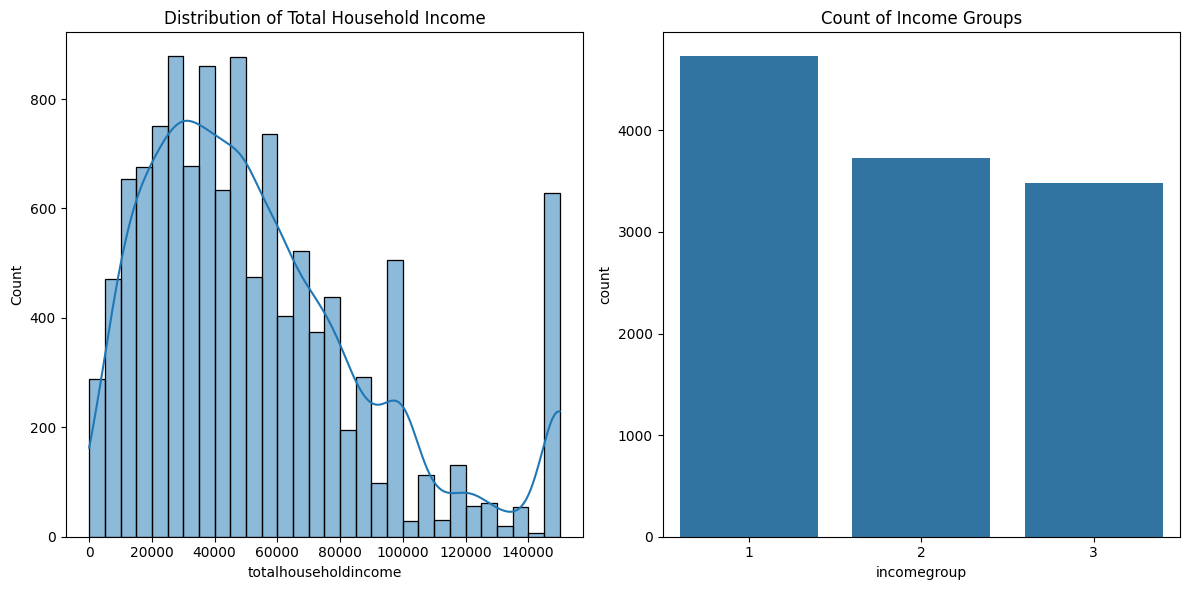

In [7]:
# Income distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(dt['totalhouseholdincome'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Total Household Income')
sns.countplot(x='incomegroup', data=dt, ax=ax[1])
ax[1].set_title('Count of Income Groups')

plt.tight_layout()
plt.show()

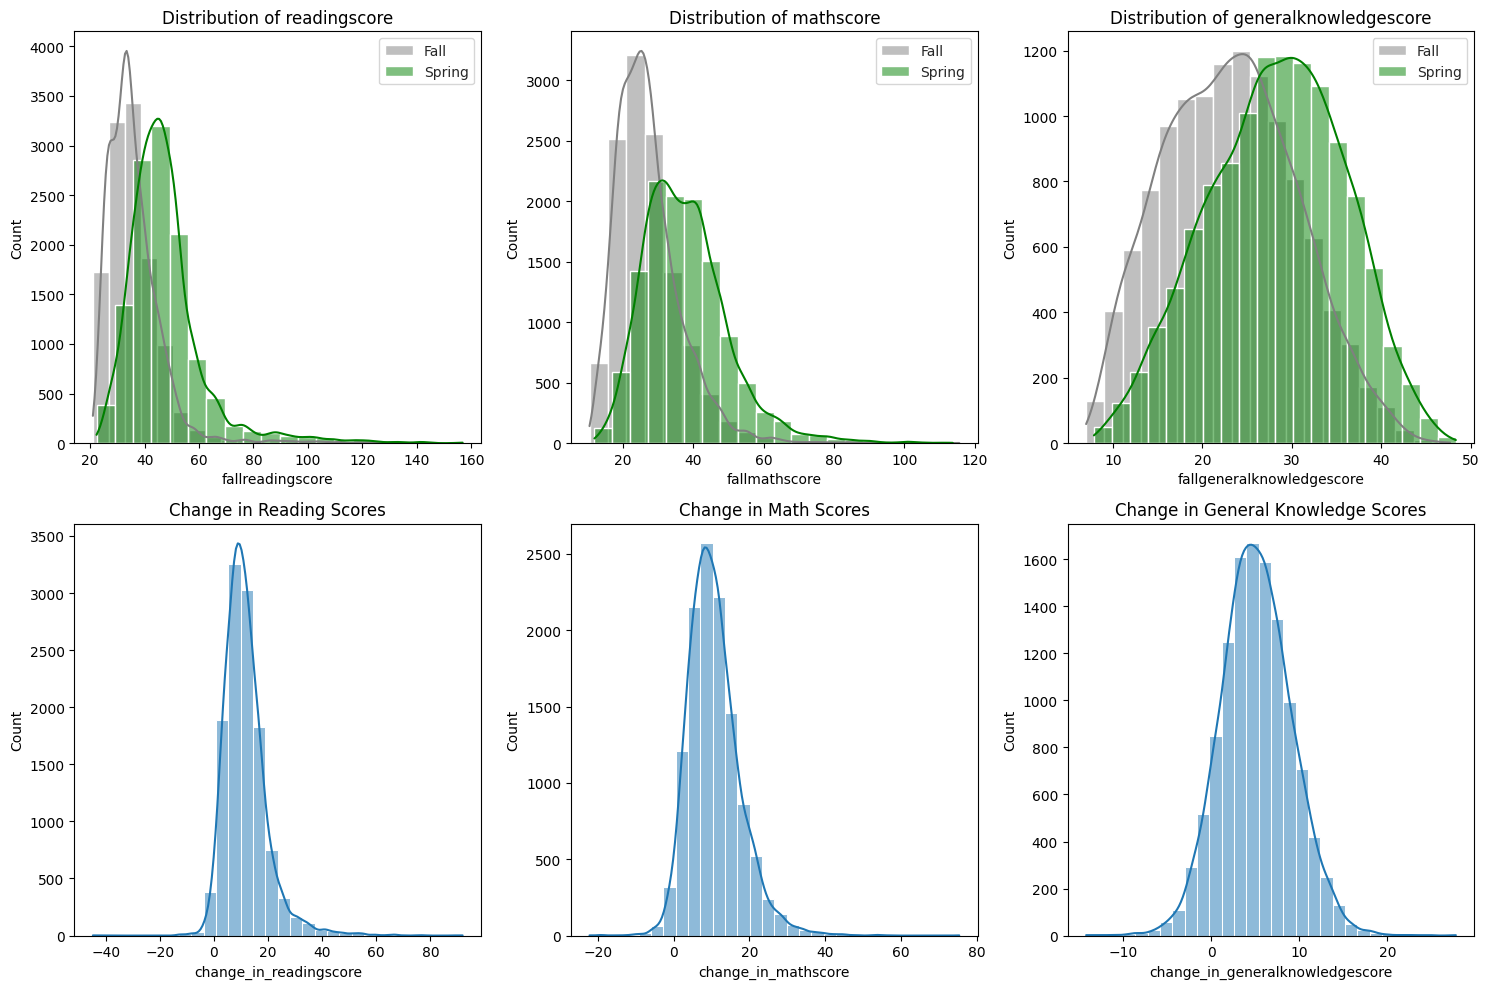

In [8]:
# Customize the figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fall_color = 'grey'
spring_color = 'green'
sns.set_style("whitegrid")

# Create subplots for each score type and distribution of changes in scores
for i, score_type in enumerate(['readingscore', 'mathscore', 'generalknowledgescore'], start=0):
    sns.histplot(dt[f'fall{score_type}'], kde=True, bins=20, label='Fall', color=fall_color, ax=axes[0, i])
    sns.histplot(dt[f'spring{score_type}'], kde=True, bins=20, color=spring_color, label='Spring', ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {score_type}')
    axes[0, i].legend()

# Calculate changes in scores from fall to spring
dt['change_in_readingscore'] = dt['springreadingscore'] - dt['fallreadingscore']
dt['change_in_mathscore'] = dt['springmathscore'] - dt['fallmathscore']
dt['change_in_generalknowledgescore'] = dt['springgeneralknowledgescore'] - dt['fallgeneralknowledgescore']

# Distribution of changes in scores
sns.histplot(dt['change_in_readingscore'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Change in Reading Scores')
sns.histplot(dt['change_in_mathscore'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Change in Math Scores')
sns.histplot(dt['change_in_generalknowledgescore'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Change in General Knowledge Scores')

# Adjust layout for better spacing
plt.tight_layout()

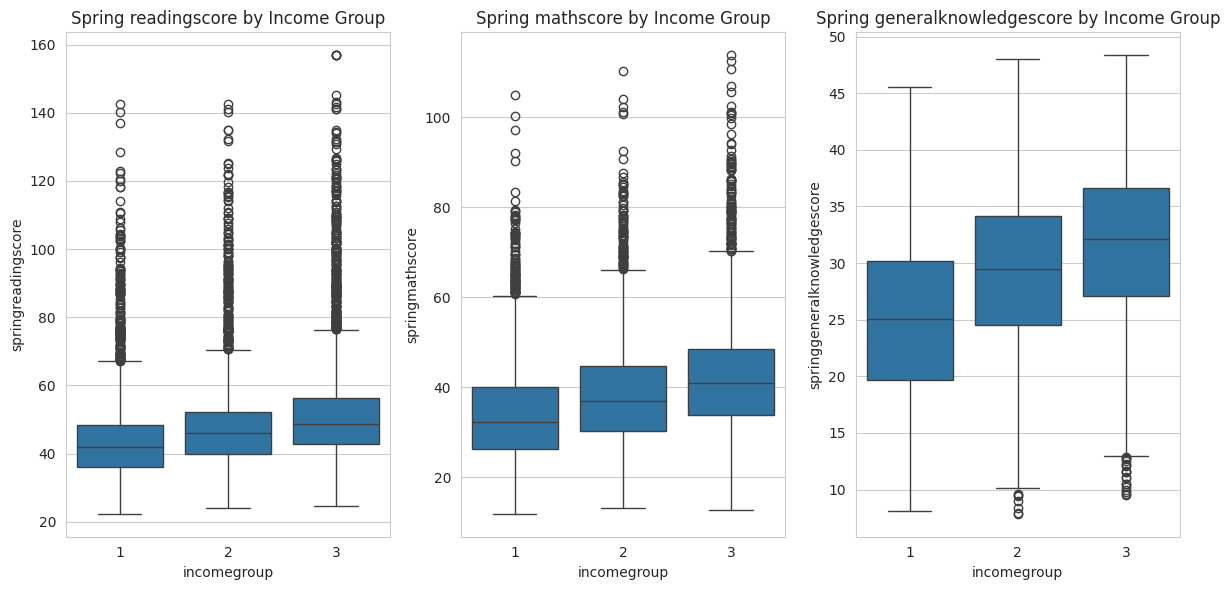

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Create subplots for scores by income group
for i, score_type in enumerate(['readingscore', 'mathscore', 'generalknowledgescore']):
    sns.boxplot(x='incomegroup', y=f'spring{score_type}', data=dt, ax=axes[i])
    axes[i].set_title(f'Spring {score_type} by Income Group')

plt.tight_layout()
plt.show()


#**ANCOVA**#



In [10]:
# Prepare data for ANCOVA by selecting relevant columns
ancova_data = dt[['change_in_readingscore', 'change_in_mathscore', 'change_in_generalknowledgescore',
                    'fallreadingscore', 'fallmathscore', 'fallgeneralknowledgescore',
                    'totalhouseholdincome', 'incomegroup']]

 **1.Does the income group influence the degree of improvement in reading scores from fall to spring, after controlling for initial fall reading scores?**


Null Hypothesis (H0): The income group does not influence the degree of improvement in reading scores from fall to spring, after controlling for initial fall reading scores.

Alternative Hypothesis (H1): The income group does influence the degree of improvement in reading scores from fall to spring, after controlling for initial fall reading scores.


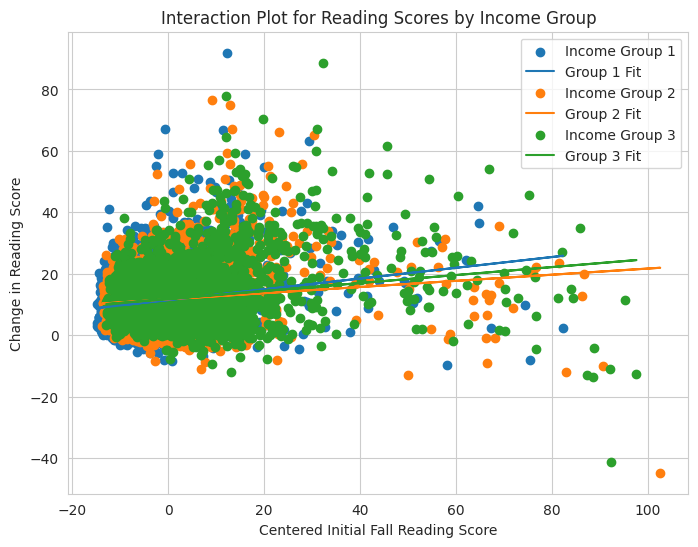

In [11]:
# Function to plot interaction effects
def plot_interaction(data, score_type):

    # Prepare the data for plotting
    data['change_in_score'] = data[f'spring{score_type}score'] - data[f'fall{score_type}score']
    data[f'fall{score_type}score_centered'] = data[f'fall{score_type}score'] - data[f'fall{score_type}score'].mean()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    for group in sorted(data['incomegroup'].unique()):
        group_data = data[data['incomegroup'] == group]
        ax.scatter(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], label=f'Income Group {group}')
        # Fit a simple linear regression
        slope, intercept = np.polyfit(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], 1)
        ax.plot(group_data[f'fall{score_type}score_centered'], intercept + slope * group_data[f'fall{score_type}score_centered'], label=f'Group {group} Fit')

    ax.set_xlabel(f'Centered Initial Fall {score_type.capitalize()} Score')
    ax.set_ylabel(f'Change in {score_type.capitalize()} Score')
    ax.set_title(f'Interaction Plot for {score_type.capitalize()} Scores by Income Group')
    ax.legend()
    plt.show()

plot_interaction(dt, 'reading')

In [12]:
# ANCOVA for Change in Reading Score with Income Group as factor and Fall Reading Score as covariate
model_read = ols('change_in_readingscore ~ C(incomegroup) + fallreadingscore', data=ancova_data).fit()
ancova_read = sm.stats.anova_lm(model_read, typ=2)

print(model_read.summary())

ancova_read


                              OLS Regression Results                              
Dep. Variable:     change_in_readingscore   R-squared:                       0.032
Model:                                OLS   Adj. R-squared:                  0.032
Method:                     Least Squares   F-statistic:                     133.5
Date:                    Sun, 24 Mar 2024   Prob (F-statistic):           4.50e-85
Time:                            03:22:51   Log-Likelihood:                -41675.
No. Observations:                   11933   AIC:                         8.336e+04
Df Residuals:                       11929   BIC:                         8.339e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

,sum_sq,df,F,PR(>F)
C(incomegroup),513.120105,2.0,4.055660,1.734793e-02
fallreadingscore,21099.608888,1.0,333.539242,1.629240e-73
Residual,754625.552188,11929.0,NaN,NaN


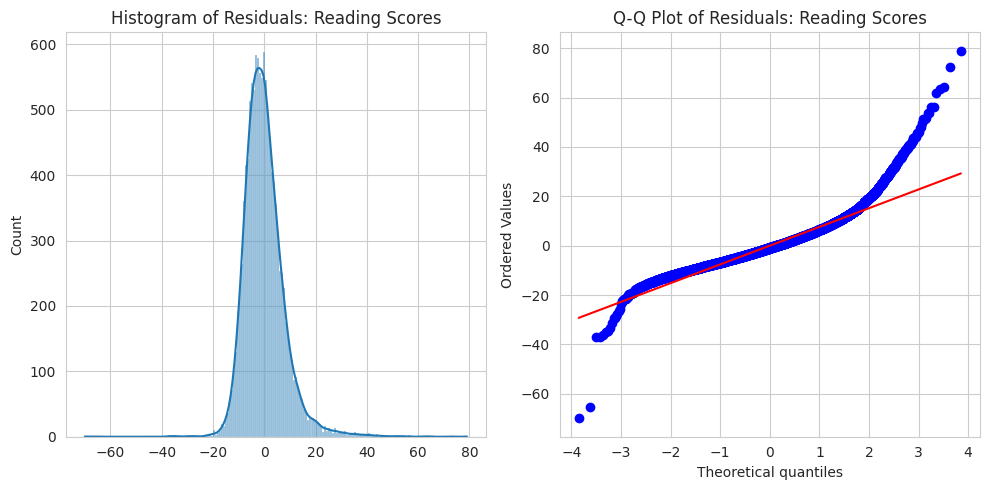

Levene's Test P-Value for Reading Scores: 2.794929503613517e-09


In [13]:
# 1. Normality of residuals
residuals_read = model_read.resid
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_read, kde=True)
plt.title('Histogram of Residuals: Reading Scores')

plt.subplot(1, 2, 2)
stats.probplot(residuals_read, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals: Reading Scores')

plt.tight_layout()
plt.show()

# 2. Homogeneity of variances
_, pval_read = stats.levene(dt['change_in_readingscore'][dt['incomegroup'] == 1],
                            dt['change_in_readingscore'][dt['incomegroup'] == 2],
                            dt['change_in_readingscore'][dt['incomegroup'] == 3])
print(f"Levene's Test P-Value for Reading Scores: {pval_read}")

In [14]:
# Post-Hoc Tests for Reading Scores
if model_read.f_pvalue < 0.05:
    tukey_read = pairwise_tukeyhsd(endog=dt['change_in_readingscore'], groups=dt['incomegroup'], alpha=0.05)
    print("Tukey's HSD Test Results for Reading Scores:")
    print(tukey_read)

Tukey's HSD Test Results for Reading Scores:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2   0.8387    0.0 0.4246 1.2527   True
     1      3   1.4301    0.0 1.0079 1.8523   True
     2      3   0.5915 0.0053 0.1458 1.0371   True
--------------------------------------------------


**2. Does the income group influence the degree of improvement in math scores from fall to spring, after controlling for initial fall math scores?**


Null Hypothesis (H0): The income group does not influence the degree of improvement in math scores from fall to spring, after controlling for initial fall math scores.

Alternative Hypothesis (H1): The income group does influence the degree of improvement in math scores from fall to spring, after controlling for initial fall math scores.

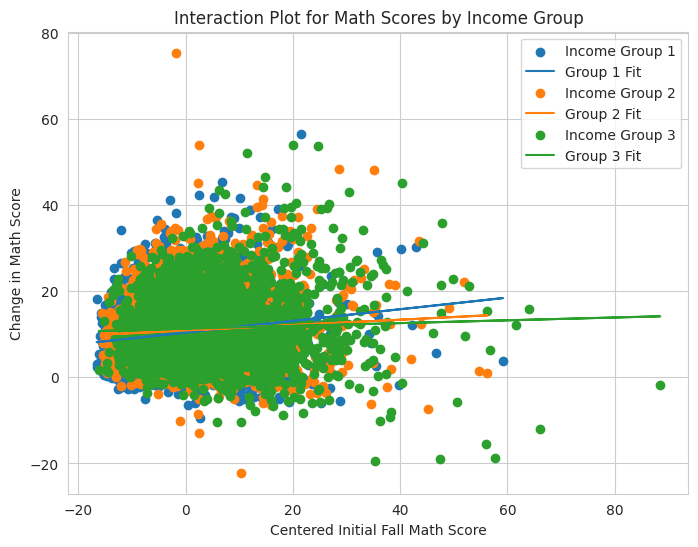

In [15]:
# Function to plot interaction effects
def plot_interaction(data, score_type):

    # Prepare the data for plotting
    data['change_in_score'] = data[f'spring{score_type}score'] - data[f'fall{score_type}score']
    data[f'fall{score_type}score_centered'] = data[f'fall{score_type}score'] - data[f'fall{score_type}score'].mean()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    for group in sorted(data['incomegroup'].unique()):
        group_data = data[data['incomegroup'] == group]
        ax.scatter(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], label=f'Income Group {group}')
        # Fit a simple linear regression
        slope, intercept = np.polyfit(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], 1)
        ax.plot(group_data[f'fall{score_type}score_centered'], intercept + slope * group_data[f'fall{score_type}score_centered'], label=f'Group {group} Fit')

    ax.set_xlabel(f'Centered Initial Fall {score_type.capitalize()} Score')
    ax.set_ylabel(f'Change in {score_type.capitalize()} Score')
    ax.set_title(f'Interaction Plot for {score_type.capitalize()} Scores by Income Group')
    ax.legend()
    plt.show()

plot_interaction(dt, 'math')

In [16]:
# ANCOVA for Change in Math Score with Income Group as factor and Fall Math Score as covariate
model_math = ols('change_in_mathscore ~ C(incomegroup) + fallmathscore', data=ancova_data).fit()
ancova_math = sm.stats.anova_lm(model_math, typ=2)

print(model_math.summary())

ancova_math

                             OLS Regression Results                            
Dep. Variable:     change_in_mathscore   R-squared:                       0.016
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     66.62
Date:                 Sun, 24 Mar 2024   Prob (F-statistic):           1.02e-42
Time:                         03:22:57   Log-Likelihood:                -39804.
No. Observations:                11933   AIC:                         7.962e+04
Df Residuals:                    11929   BIC:                         7.965e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

,sum_sq,df,F,PR(>F)
C(incomegroup),1712.758286,2.0,18.523585,9.284861e-09
fallmathscore,4806.990621,1.0,103.975792,2.576573e-24
Residual,551499.442116,11929.0,NaN,NaN


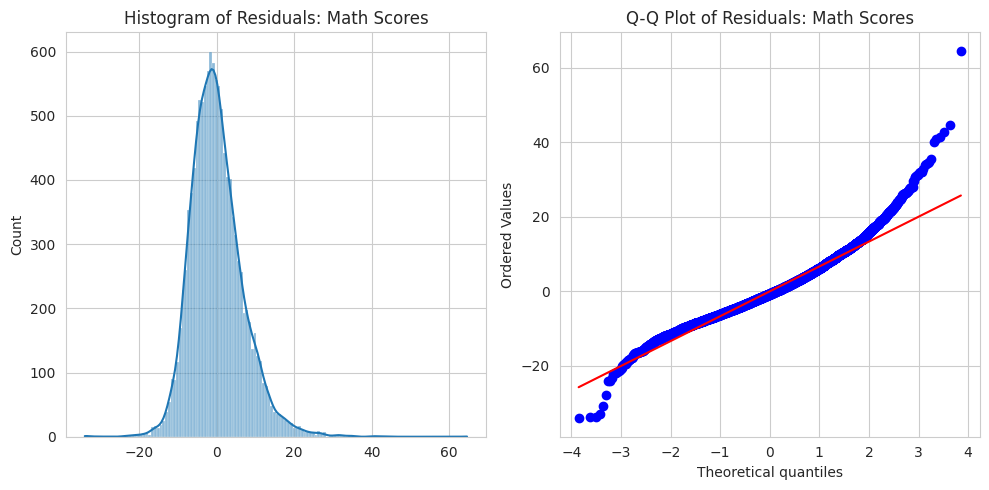

Levene's Test P-Value for Math Scores: 2.344180384098772e-10


In [17]:
# Assumption Checks for Math Scores

# 1. Normality of residuals
residuals_math = model_math.resid
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_math, kde=True)
plt.title('Histogram of Residuals: Math Scores')

plt.subplot(1, 2, 2)
stats.probplot(residuals_math, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals: Math Scores')

plt.tight_layout()
plt.show()

# 2. Homogeneity of variances
_, pval_math = stats.levene(dt['change_in_mathscore'][dt['incomegroup'] == 1],
                            dt['change_in_mathscore'][dt['incomegroup'] == 2],
                            dt['change_in_mathscore'][dt['incomegroup'] == 3])
print(f"Levene's Test P-Value for Math Scores: {pval_math}")



In [18]:
# Post-Hoc Tests for Math Scores
if model_math.f_pvalue < 0.05:
    tukey_math = pairwise_tukeyhsd(endog=dt['change_in_mathscore'], groups=dt['incomegroup'], alpha=0.05)
    print("Tukey's HSD Test Results for Math Scores:")
    print(tukey_math)

Tukey's HSD Test Results for Math Scores:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2   0.9377    0.0 0.5871 1.2883   True
     1      3   1.4406    0.0 1.0831 1.7982   True
     2      3    0.503 0.0051 0.1256 0.8803   True
--------------------------------------------------


**3. Does the income group influence the degree of improvement in general knowledge scores from fall to spring, after controlling for initial fall general knowledge scores?**  

(not in the report document due to page limitation)

Null Hypothesis (H0): The income group does not influence the degree of improvement in general knowledge scores from fall to spring, after controlling for initial fall general knowledge scores.

Alternative Hypothesis (H1): The income group does influence the degree of improvement in general knowledge scores from fall to spring, after controlling for initial fall general knowledge scores.

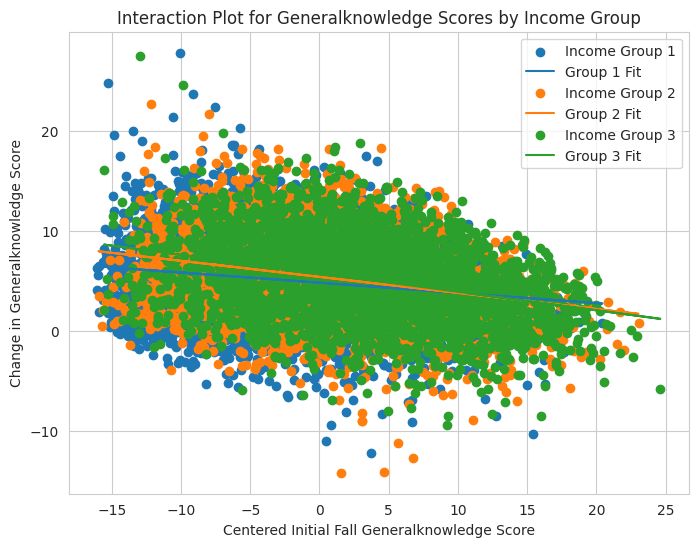

In [19]:
# Function to plot interaction effects
def plot_interaction(data, score_type):

    # Prepare the data for plotting
    data['change_in_score'] = data[f'spring{score_type}score'] - data[f'fall{score_type}score']
    data[f'fall{score_type}score_centered'] = data[f'fall{score_type}score'] - data[f'fall{score_type}score'].mean()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    for group in sorted(data['incomegroup'].unique()):
        group_data = data[data['incomegroup'] == group]
        ax.scatter(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], label=f'Income Group {group}')
        # Fit a simple linear regression
        slope, intercept = np.polyfit(group_data[f'fall{score_type}score_centered'], group_data['change_in_score'], 1)
        ax.plot(group_data[f'fall{score_type}score_centered'], intercept + slope * group_data[f'fall{score_type}score_centered'], label=f'Group {group} Fit')

    ax.set_xlabel(f'Centered Initial Fall {score_type.capitalize()} Score')
    ax.set_ylabel(f'Change in {score_type.capitalize()} Score')
    ax.set_title(f'Interaction Plot for {score_type.capitalize()} Scores by Income Group')
    ax.legend()
    plt.show()

plot_interaction(dt, 'generalknowledge')

In [20]:
# ANCOVA for Change in General Knowledge Score with Income Group as factor and Fall General Knowledge Score as covariate
model_gk = ols('change_in_generalknowledgescore ~ C(incomegroup) + fallgeneralknowledgescore', data=ancova_data).fit()
ancova_gk = sm.stats.anova_lm(model_gk, typ=2)

print(model_gk.summary())

ancova_gk

                                   OLS Regression Results                                  
Dep. Variable:     change_in_generalknowledgescore   R-squared:                       0.061
Model:                                         OLS   Adj. R-squared:                  0.061
Method:                              Least Squares   F-statistic:                     260.2
Date:                             Sun, 24 Mar 2024   Prob (F-statistic):          1.43e-163
Time:                                     03:23:03   Log-Likelihood:                -33259.
No. Observations:                            11933   AIC:                         6.653e+04
Df Residuals:                                11929   BIC:                         6.656e+04
Df Model:                                        3                                         
Covariance Type:                         nonrobust                                         
                                coef    std err          t      P>|t|      [0.02

,sum_sq,df,F,PR(>F)
C(incomegroup),1756.904469,2.0,56.908040,2.525291e-25
fallgeneralknowledgescore,12001.111256,1.0,777.458001,8.324769e-166
Residual,184140.179925,11929.0,NaN,NaN


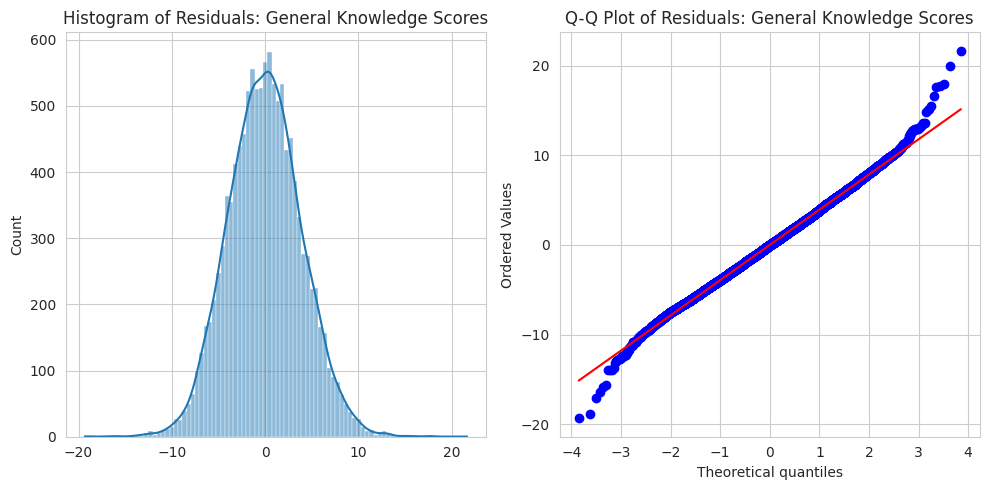

Levene's Test P-Value for General Knowledge Scores: 0.9577965167131874


In [21]:
# 1. Normality of residuals
residuals_gk = model_gk.resid
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_gk, kde=True)
plt.title('Histogram of Residuals: General Knowledge Scores')

plt.subplot(1, 2, 2)
stats.probplot(residuals_gk, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals: General Knowledge Scores')

plt.tight_layout()
plt.show()

# 2. Homogeneity of variances
_, pval_gk = stats.levene(dt['change_in_generalknowledgescore'][dt['incomegroup'] == 1],
                          dt['change_in_generalknowledgescore'][dt['incomegroup'] == 2],
                          dt['change_in_generalknowledgescore'][dt['incomegroup'] == 3])

print(f"Levene's Test P-Value for General Knowledge Scores: {pval_gk}")

In [22]:
# Post-Hoc Tests for General Knowledge Scores
if model_gk.f_pvalue < 0.05:
    tukey_gk = pairwise_tukeyhsd(endog=dt['change_in_generalknowledgescore'], groups=dt['incomegroup'], alpha=0.05)
    print("Tukey's HSD Test Results for General Knowledge Scores:")
    print(tukey_gk)

Tukey's HSD Test Results for General Knowledge Scores:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.1339 0.2873 -0.0743 0.3421  False
     1      3  -0.0059 0.9976 -0.2182 0.2064  False
     2      3  -0.1399  0.309 -0.3639 0.0842  False
---------------------------------------------------
